In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os



# Extract Image Data

In [2]:
img = image.load_img("/Users/Wajehah/Desktop/Explainable-Pneumonia-Detection-via-Chest-Xray-Images/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")

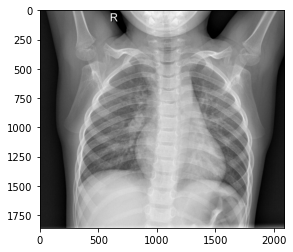

In [3]:
plt.imshow(img)

In [4]:
#generate training and validation dataset; normalize metrics

train_datagen = ImageDataGenerator(rescale = 1/255)
validation_datagen = ImageDataGenerator(rescale = 1/255)

In [5]:
#convert images to dataset, resize to make all uniform in size, and create batches of data

train_generator = train_datagen.flow_from_directory(
    '/Users/Wajehah/Desktop/Explainable-Pneumonia-Detection-via-Chest-Xray-Images/chest_xray/chest_xray/train/',
    target_size=(200,200), #pixel size, will be resized to 150x150
    batch_size = 128, #neural network will train images in batches of 10
    class_mode = 'binary') #two classifications

validation_generator = validation_datagen.flow_from_directory(
    '/Users/Wajehah/Desktop/Explainable-Pneumonia-Detection-via-Chest-Xray-Images/chest_xray/chest_xray/val/',
    target_size=(200,200),
    batch_size = 128, #neural network will train images in batches of 10
    class_mode = 'binary') #two classifications

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [6]:
#view label names

train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [ ]:
# Define the K-fold Cross Validator

#num_folds = 5
#fold_no = 1
#epochs = 10
#inputs = np.concatenate((x_train, x_test), axis=0)
#targets = np.concatenate((y_train, y_test), axis=0)

# Define per-fold score containers
#acc_per_fold = []
#loss_per_fold = []

#kfold = KFold(n_splits=num_folds, shuffle=True)


# Build CNN Model

In [7]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes of color
    # This is the first convolution
    
    tf.keras.layers.Conv2D(16, (3,3),activation = 'relu', input_shape = (200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The second convolution                       
    tf.keras.layers.Conv2D(32, (3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The third convolution                    
    tf.keras.layers.Conv2D(64, (3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fourth convolution                    
    tf.keras.layers.Conv2D(64, (3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # The fifth convolution                    
    tf.keras.layers.Conv2D(64, (3,3),activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    # Flatten the results to feed into the DNN
    tf.keras.layers.Flatten(),
    
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512,activation = 'relu'),
                                    
    # Ony 1 output neuron.  It will contain a value from 0-1 for 1 class ('normal') and 1 for the other ('pnuemonia')
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])
                                    

2022-06-10 15:57:32.248882: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-10 15:57:32.249141: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.compile(loss='binary_crossentropy',
             optimizer = RMSprop(lr=0.001),
             metrics = (['accuracy'],
                    [tf.keras.metrics.Precision()],
                    [tf.keras.metrics.Recall()],
                    [tf.keras.metrics.AUC()]))
              

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

In [17]:
#add callbacks
#creates CSV file of epochs, acc, loss, val_acc, val_loss

log_csv = CSVLogger('my_logs.csv', separator=',', append=False)  

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if (logs.get('accuracy') > .98) & (logs.get('val_accuracy') > .9):
          print("Reached 98% accuracy so cancelling training!")
          self.model.stop_training = True
callbacks = myCallback()

callbacks_list = [callbacks, log_csv]

# Fit the Model

In [18]:

history = model.fit(
    train_generator,
    steps_per_epoch = 1,
    epochs = 200,
    validation_data = validation_generator, 
    callbacks=callbacks_list)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.0556 - accuracy: 0.9844 - precision: 1.0000 - recall: 0.9789 - auc: 0.9994 - val_loss: 8.2732 - val_accuracy: 0.5625 - val_precision: 0.5333 - val_recall: 1.0000 - val_auc: 0.5625
Epoch 2/200
1/1 [==============================] - 3s 3s/step - loss: 2.4944 - accuracy: 0.7969 - precision: 0.7920 - recall: 1.0000 - auc: 0.6724 - val_loss: 0.2892 - val_accuracy: 0.8750 - val_precision: 1.0000 - val_recall: 0.7500 - val_auc: 0.9844
Epoch 3/200
1/1 [==============================] - 2s 2s/step - loss: 0.3346 - accuracy: 0.8958 - precision: 1.0000 - recall: 0.8507 - auc: 0.9838 - val_loss: 1.3005 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_auc: 0.8594
Epoch 4/200
1/1 [==============================] - 2s 2s/step - loss: 0.2838 - accuracy: 0.8984 - precision: 0.8796 - recall: 1.0000 - auc: 0.9687 - val_loss: 0.2977 - val_accuracy: 0.8750 - val_precision: 0.8750 - val_recall: 0.8750 - val_auc:

In [19]:
#save model to a folder
model.save('pnuemonia_detection_model')

INFO:tensorflow:Assets written to: pnuemonia_detection_model/assets


# Evaluate the Model

In [21]:
#train_loss, train_acc = 
model.evaluate(train_generator, steps=16)
#test_loss, test_acc = 
model.evaluate(validation_generator, steps=16)

print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

16/16 [==============================] - 0s 1ms/step - loss: 0.3224 - accuracy: 0.9375 - precision: 0.8889 - recall: 1.0000 - auc: 0.9766
Train: 0.969, Test: 0.875


Values stored in history are ... /n {'loss': [0.055633410811424255, 2.4943809509277344, 0.3345617353916168, 0.2838214039802551, 0.12463187426328659, 0.05459413677453995, 0.05143608897924423, 0.07307995855808258, 0.07313048839569092, 0.0936989039182663, 0.10109882801771164, 0.1435994654893875, 0.03737398609519005, 0.11105974018573761, 0.12489686906337738, 0.14455492794513702, 0.06117386743426323, 0.15809562802314758, 0.09941078722476959, 0.10514208674430847, 0.13735342025756836, 0.05372139438986778, 0.061500433832407, 0.05153683200478554, 0.0979963093996048, 0.08600529283285141, 0.06815483421087265, 0.1293797343969345, 0.11835403740406036, 0.14046858251094818, 0.05465441942214966, 0.07444871962070465, 0.10950364172458649, 0.06293709576129913, 0.12041536718606949, 0.05890880525112152, 0.08105665445327759, 0.07619267702102661, 0.08343600481748581, 0.20144706964492798, 0.1524588167667389, 0.06008180230855942], 'accuracy': [0.984375, 0.796875, 0.8958333134651184, 0.8984375, 0.9453125, 0.976

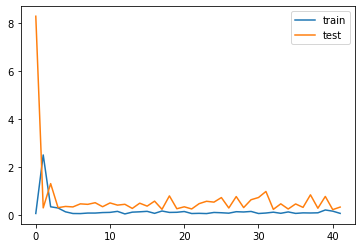

In [22]:
print("Values stored in history are ... /n", history.history)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
import pandas as pd


In [24]:
df = pd.read_csv('my_logs.csv')
df

,epoch,accuracy,auc,loss,precision,recall,val_accuracy,val_auc,val_loss,val_precision,val_recall
0,0,0.984375,0.999362,0.055633,1.000000,0.978947,0.5625,0.562500,8.273165,0.533333,1.000
1,1,0.796875,0.672414,2.494381,0.792000,1.000000,0.8750,0.984375,0.289232,1.000000,0.750
2,2,0.895833,0.983788,0.334562,1.000000,0.850746,0.7500,0.859375,1.300466,0.666667,1.000
3,3,0.898438,0.968740,0.283821,0.879630,1.000000,0.8750,0.953125,0.297738,0.875000,0.875
4,4,0.945312,0.985515,0.124632,0.970000,0.960396,0.8750,0.953125,0.348867,0.800000,1.000
5,5,0.976562,0.998748,0.054594,0.978947,0.989362,0.8750,0.953125,0.328724,0.800000,1.000
6,6,0.984375,1.000000,0.051436,1.000000,0.979167,0.8750,0.953125,0.456425,0.800000,1.000
7,7,0.968750,0.996399,0.073080,0.967033,0.988764,0.8750,0.953125,0.436455,0.800000,1.000
8,8,0.976562,0.996259,0.073130,0.989691,0.979592,0.8125,0.953125,0.504172,0.727273,1.000
9,9,0.953125,0.992685,0.093699,0.960396,0.979798,0.8125,0.953125,0.337178,0.777778,0.875


In [30]:
results = df[["accuracy", "precision", "recall", "auc"]]


In [32]:
final_results = results.iloc[41:]
final_results

,accuracy,precision,recall,auc
41,0.992188,0.989691,1.0,0.999023
